In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=199dba07308da7d8d21b1e55a829d05c0378cee14e4363eb359aab22fffa1320
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
import os
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import mean
from pyspark.sql.functions import when
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
import sys
from pyspark.sql.functions import year, month, dayofmonth
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("AirQuality").config("spark.sql.debug.maxToStringFields", 1000).getOrCreate()

# Preparing Data

In [3]:
Dir = '/kaggle/input/time-series-air-quality-data-of-india-2010-2023/'

In [4]:
names = []
station = 'stations_info.csv'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename != station:
            names.append(filename)

#### Stations Data

In [5]:
stations = spark.read.csv(Dir+station,header=True,inferSchema=True) 
stations.printSchema()

root
 |-- file_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- agency: string (nullable = true)
 |-- station_location: string (nullable = true)
 |-- start_month: string (nullable = true)
 |-- start_month_num: integer (nullable = true)
 |-- start_year: integer (nullable = true)



In [6]:
stations = stations.select('file_name','state','city','start_month_num','start_year')
stations.printSchema()

root
 |-- file_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- start_month_num: integer (nullable = true)
 |-- start_year: integer (nullable = true)



#### Atmosphere Data

In [7]:
data = spark.read.csv(Dir + names[0], header=True, inferSchema=True)
state_df = stations.filter(stations.file_name == names[0][:-4])
data = data.withColumn('state', lit(state_df.first()[1]))
data = data.withColumn('city', lit(state_df.first()[2]))
data = data.withColumn('start_month_num', lit(state_df.first()[3]))
data = data.withColumn('start_year', lit(state_df.first()[4]))

In [8]:
for name in names[1:]:
    df = spark.read.csv(Dir + name, header=True, inferSchema=True)
    
    state_df = stations.filter(stations.file_name == name[:-4])
    df = df.withColumn('state', lit(state_df.first()[1]))
    df = df.withColumn('city', lit(state_df.first()[2]))
    df = df.withColumn('start_month_num', lit(state_df.first()[3]))
    df = df.withColumn('start_year', lit(state_df.first()[4]))
    
    if len(data.columns) == len(df.columns):
        data = data.union(df)


# Preprocessing

#### What are the types of columns?

In [9]:
data.printSchema()

root
 |-- From Date: timestamp (nullable = true)
 |-- To Date: timestamp (nullable = true)
 |-- PM2.5 (ug/m3): double (nullable = true)
 |-- PM10 (ug/m3): double (nullable = true)
 |-- NO (ug/m3): string (nullable = true)
 |-- NO2 (ug/m3): double (nullable = true)
 |-- NOx (ppb): string (nullable = true)
 |-- NH3 (ug/m3): string (nullable = true)
 |-- SO2 (ug/m3): double (nullable = true)
 |-- CO (ug/m3): double (nullable = true)
 |-- Ozone (ug/m3): double (nullable = true)
 |-- Benzene (ug/m3): string (nullable = true)
 |-- Toluene (): string (nullable = true)
 |-- Temp (degree C): string (nullable = true)
 |-- RH (%): string (nullable = true)
 |-- WS (m/s): string (nullable = true)
 |-- WD (degree): string (nullable = true)
 |-- SR (W/mt2): string (nullable = true)
 |-- BP (mmHg): string (nullable = true)
 |-- VWS (m/s): string (nullable = true)
 |-- AT (degree C): string (nullable = true)
 |-- RF (mm): string (nullable = true)
 |-- state: string (nullable = false)
 |-- city: string 

#### Renaming Columns because PM2.5 gives error on various operations

In [10]:

column_rename_mapping = {
    'From Date': 'from_date',
    'To Date': 'to_date',
    'PM2.5 (ug/m3)': 'pm2_5',
    'PM10 (ug/m3)': 'pm10',
    'NO (ug/m3)': 'no',
    'NO2 (ug/m3)': 'no2',
    'NOx (ppb)': 'nox',
    'NH3 (ug/m3)': 'nh3',
    'SO2 (ug/m3)': 'so2',
    'CO (ug/m3)': 'co',
    'Ozone (ug/m3)': 'ozone',
    'Benzene (ug/m3)': 'benzene',
    'Toluene ()': 'toluene',
    'Temp (degree C)': 'temp_c',
    'RH (%)': 'rh_percent',
    'WS (m/s)': 'ws_m_s',
    'WD (degree)': 'wd_degree',
    'SR (W/mt2)': 'sr_w_mt2',
    'BP (mmHg)': 'bp_mmhg',
    'VWS (m/s)': 'vws_m_s',
    'AT (degree C)': 'at_c',
    'RF (mm)': 'rf_mm',
    'state': 'state',
    'city': 'city',
    'start_month_num': 'start_month_num',
    'start_year': 'start_year'
}

for old_name, new_name in column_rename_mapping.items():
    data = data.withColumnRenamed(old_name, new_name)

#### How large is data?

In [11]:
data.count()

2721950

#### Is there any nulls values?

In [12]:
null_counts = {}

for column in data.columns:
    null_count = data.where(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    print(f"{column} : {count} null values")


from_date : 0 null values
to_date : 0 null values
pm2_5 : 523137 null values
pm10 : 572473 null values
no : 542527 null values
no2 : 479700 null values
nox : 480861 null values
nh3 : 515893 null values
so2 : 426277 null values
co : 405916 null values
ozone : 568654 null values
benzene : 805462 null values
toluene : 893971 null values
temp_c : 1540515 null values
rh_percent : 971827 null values
ws_m_s : 752559 null values
wd_degree : 461451 null values
sr_w_mt2 : 547017 null values
bp_mmhg : 812752 null values
vws_m_s : 1317304 null values
at_c : 1247751 null values
rf_mm : 874377 null values
state : 0 null values
city : 0 null values
start_month_num : 0 null values
start_year : 0 null values


#### Filling null values with mean

In [13]:
from pyspark.sql.functions import mean
cols = ['pm2_5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'so2', 'co', 'ozone','benzene', 'toluene', 'temp_c', 'rh_percent', 'ws_m_s', 'wd_degree',
                  'sr_w_mt2', 'bp_mmhg', 'vws_m_s', 'at_c', 'rf_mm']

for col in cols:
    mean_value = data.select(mean(col)).collect()[0][0]
    data = data.fillna({col: mean_value})


# Outliers

In [14]:
def OutlierCount(numerical_features):
    quantiles = data.approxQuantile(numerical_features, [0.25, 0.75], 0.05)

    print("Quantiles:", quantiles)

    iqr = dict(zip(numerical_features, [q3 - q1 for q1, q3 in zip(quantiles[0], quantiles[1])]))

    print("IQR:", iqr)

    outliers = data.select([col(c).between(q1 - 1.5 * iqr[c], q3 + 1.5 * iqr[c]).alias(c) for c, q1, q3 in zip(numerical_features, quantiles[0], quantiles[1])]).toPandas()

    print("Outlier count:")
    print(outliers.sum())


In [31]:
numerical_features = ['no2', 'so2','co', 'ozone','pm2_5', 'pm10']
for i in range(0, len(numerical_features), 2):
    OutlierCount([numerical_features[i], numerical_features[i+1] if i+1 < len(numerical_features) else None])


Quantiles: [[12.16, 29.89786129557364], [3.94, 11.88]]
IQR: {'no2': -8.22, 'so2': -18.01786129557364}


Outlier count:
no2    0
so2    0
dtype: int64


Quantiles: [[0.52, 2.12], [8.64, 29.79]]
IQR: {'co': 8.120000000000001, 'ozone': 27.669999999999998}


Outlier count:
co       2635337
ozone    2508285
dtype: int64


Quantiles: [[31.64, 76.49688833929945], [71.07, 159.5]]
IQR: {'pm2_5': 39.42999999999999, 'pm10': 83.00311166070055}


Outlier count:
pm2_5    2386672
pm10     2443386
dtype: int64


# Feature Engineering

#### Creating Output Column using formula 

In [16]:
def calculate_aqi(pm25, pm10, no2, so2, co, ozone):
    pm25_breakpoints = [0, 12.1, 35.5, 55.5, 150.5, 250.5, 350.5, 500.5]
    pm25_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    pm10_breakpoints = [0, 54, 154, 254, 354, 424, 504, 604]
    pm10_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    no2_breakpoints = [0, 54, 101, 361, 650, 1250, 1650, 2050]
    no2_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    so2_breakpoints = [0, 35, 75, 185, 304, 604, 804, 1004]
    so2_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    co_breakpoints = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 40.5, 50.5]
    co_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    ozone_breakpoints = [0, 55, 71, 86, 106, 200, 270, 360]
    ozone_aqi_ranges = [0, 50, 100, 150, 200, 300, 400, 500]

    aqi_pm25 = calculate_aqi_component(pm25, pm25_breakpoints, pm25_aqi_ranges)
    aqi_pm10 = calculate_aqi_component(pm10, pm10_breakpoints, pm10_aqi_ranges)
    aqi_no2 = calculate_aqi_component(no2, no2_breakpoints, no2_aqi_ranges)
    aqi_so2 = calculate_aqi_component(so2, so2_breakpoints, so2_aqi_ranges)
    aqi_co = calculate_aqi_component(co, co_breakpoints, co_aqi_ranges)
    aqi_ozone = calculate_aqi_component(ozone, ozone_breakpoints, ozone_aqi_ranges)
    
    overall_aqi = greatest_aqi(aqi_pm25, aqi_pm10, aqi_no2, aqi_so2, aqi_co, aqi_ozone)
    
    return overall_aqi

def calculate_aqi_component(value, breakpoints, aqi_ranges):
    index = 0
    for i, breakpoint in enumerate(breakpoints):
        if value <= breakpoint:
            index = i
            break
    else:
        index = len(breakpoints) - 1
    
    return ((aqi_ranges[index] - aqi_ranges[index - 1]) / (breakpoints[index] - breakpoints[index - 1])) * (value - breakpoints[index - 1]) + aqi_ranges[index - 1]

def greatest_aqi(*args):
    return max(args)


In [17]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col

calculate_aqi_udf = udf(lambda pm25, pm10, no2, so2, co, ozone: calculate_aqi(pm25, pm10, no2, so2, co, ozone), DoubleType())

data = data.withColumn("AQI", calculate_aqi_udf(col("pm2_5"), col("pm10"), col("no2"), col("so2"), col("co"), col("ozone")))

In [18]:
relevant_columns = ['from_date','to_date', 'pm2_5', 'pm10', 'no2', 'so2', 'co', 'ozone','state','city' ,'AQI']

data = data.select(*relevant_columns)

In [19]:
data = data.withColumn("AQI_lag1", lag("AQI", 1).over(Window.partitionBy("city").orderBy("from_date")))
data = data.withColumn("AQI_lag2", lag("AQI", 2).over(Window.partitionBy("city").orderBy("from_date")))

data = data.withColumn("year", year("from_date"))

# EDA

In [20]:
data.printSchema()

root
 |-- from_date: timestamp (nullable = true)
 |-- to_date: timestamp (nullable = true)
 |-- pm2_5: double (nullable = false)
 |-- pm10: double (nullable = false)
 |-- no2: double (nullable = false)
 |-- so2: double (nullable = false)
 |-- co: double (nullable = false)
 |-- ozone: double (nullable = false)
 |-- state: string (nullable = false)
 |-- city: string (nullable = false)
 |-- AQI: double (nullable = true)
 |-- AQI_lag1: double (nullable = true)
 |-- AQI_lag2: double (nullable = true)
 |-- year: integer (nullable = true)



In [21]:
# Descriptive statistics
numerical_features = ['no2', 'so2','co', 'ozone','pm2_5', 'pm10']
for feature in numerical_features:
    data.select(feature).describe().show()


+-------+------------------+
|summary|               no2|
+-------+------------------+
|  count|           2721950|
|   mean|29.897861295575733|
| stddev|30.015702838779973|
|    min|               0.0|
|    max|             500.0|
+-------+------------------+



+-------+------------------+
|summary|               so2|
+-------+------------------+
|  count|           2721950|
|   mean|11.748120093758928|
| stddev|13.544440874784788|
|    min|               0.0|
|    max|             200.0|
+-------+------------------+



+-------+------------------+
|summary|                co|
+-------+------------------+
|  count|           2721950|
|   mean|3.4603169469875756|
| stddev|12.265883886695876|
|    min|               0.0|
|    max|            486.59|
+-------+------------------+



+-------+------------------+
|summary|             ozone|
+-------+------------------+
|  count|           2721950|
|   mean|29.175649241906918|
| stddev|28.119572446947547|
|    min|               0.0|
|    max|             200.0|
+-------+------------------+



+-------+-----------------+
|summary|            pm2_5|
+-------+-----------------+
|  count|          2721950|
|   mean| 76.4968883393061|
| stddev|73.92794892407943|
|    min|             0.01|
|    max|           1000.0|
+-------+-----------------+



+-------+------------------+
|summary|              pm10|
+-------+------------------+
|  count|           2721950|
|   mean|151.14650354945906|
| stddev|117.28774253591564|
|    min|              0.01|
|    max|            1000.0|
+-------+------------------+



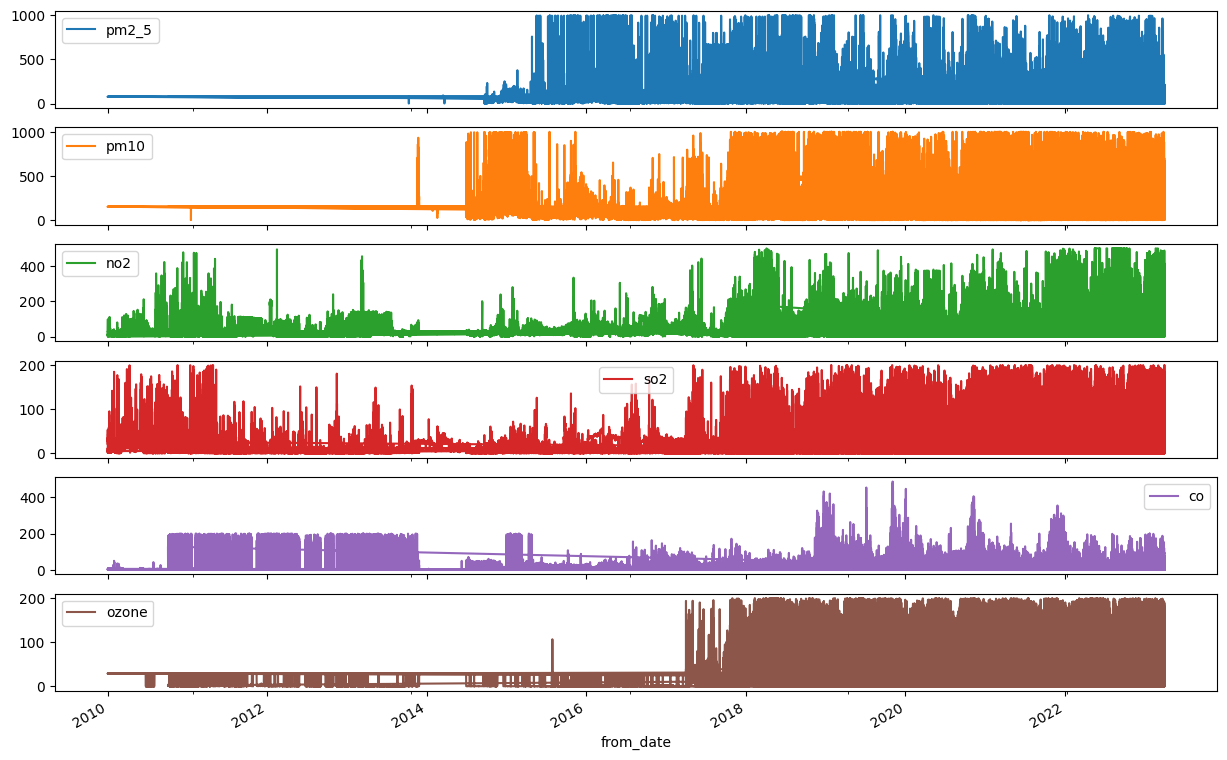

In [24]:
data.select('from_date', 'pm2_5', 'pm10', 'no2', 'so2', 'co', 'ozone').toPandas().plot(x='from_date', subplots=True, figsize=(15, 10))
plt.show()


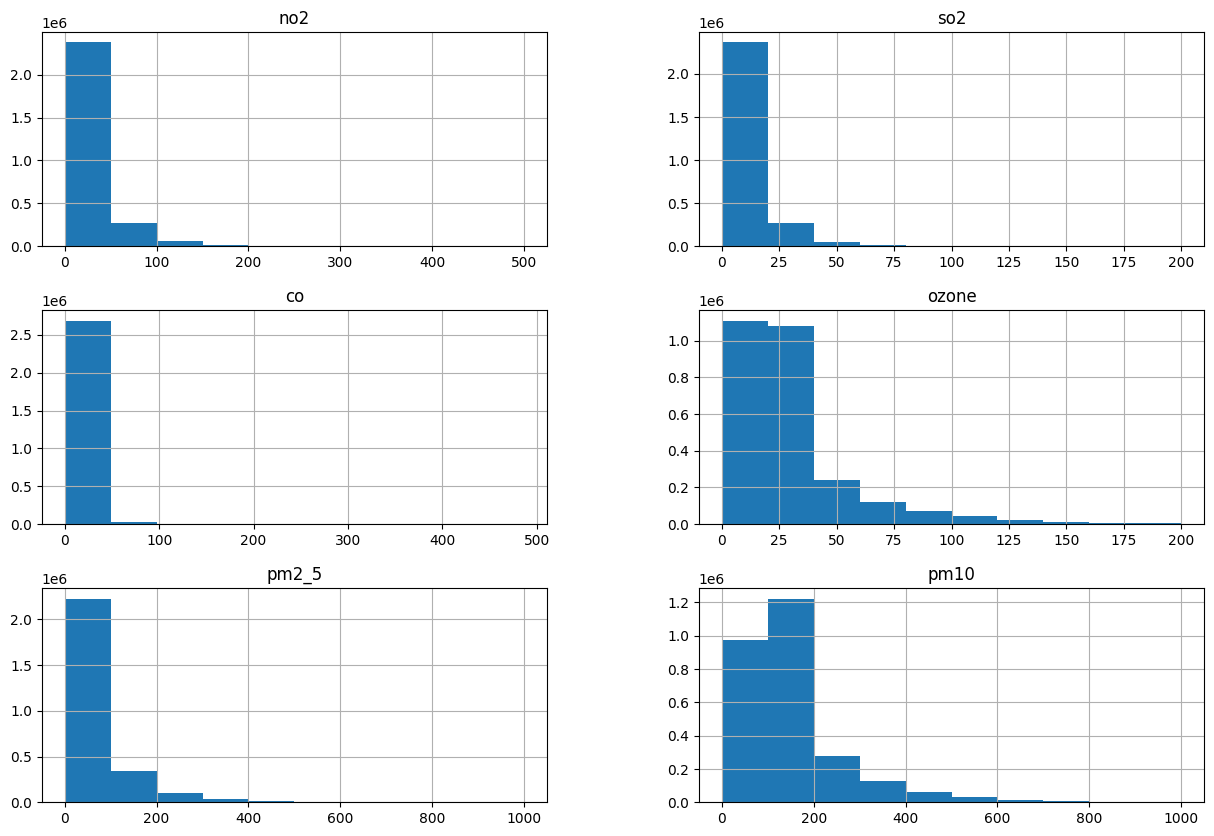

In [25]:
# Histograms of numerical features
data.select(numerical_features).toPandas().hist(figsize=(15, 10))
plt.show()

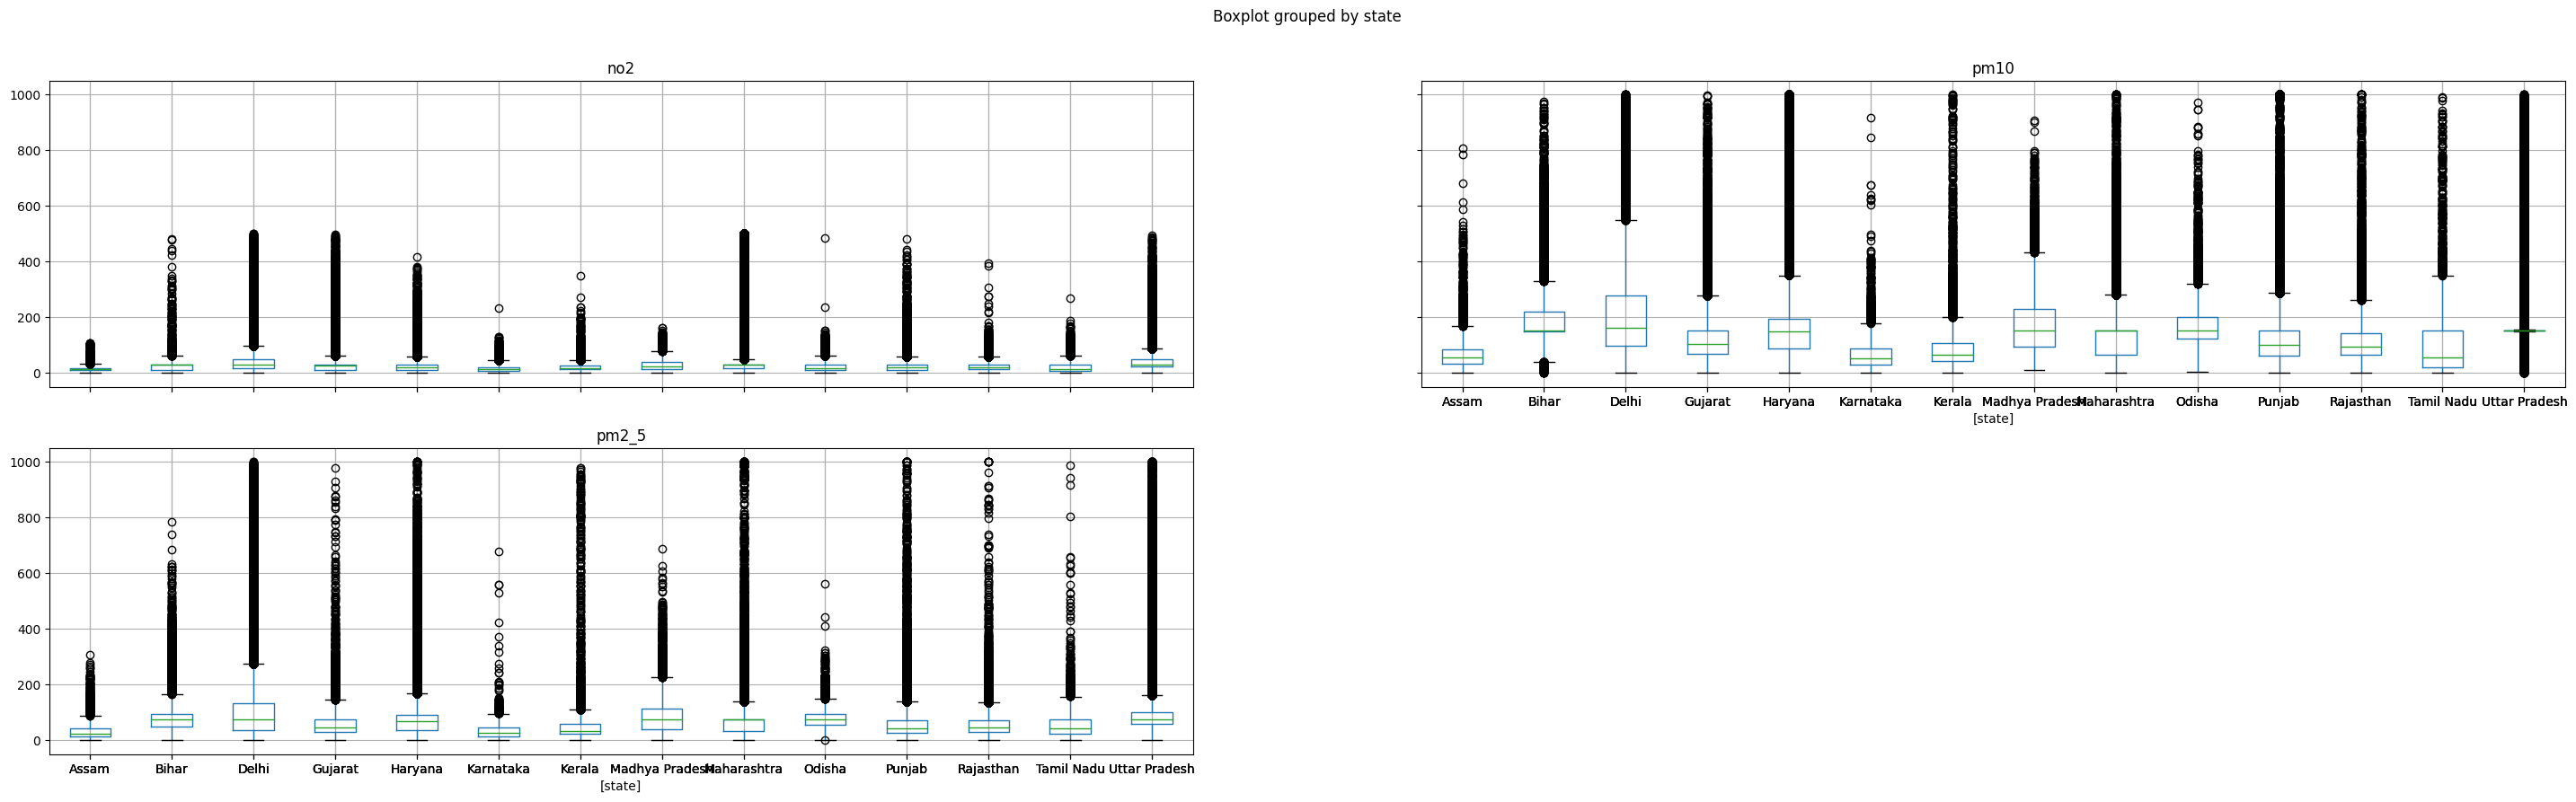

In [26]:
# Boxplots or violin plots for categorical variables
data.select('state', 'pm2_5', 'pm10', 'no2').toPandas().boxplot(by='state', figsize=(35, 10))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


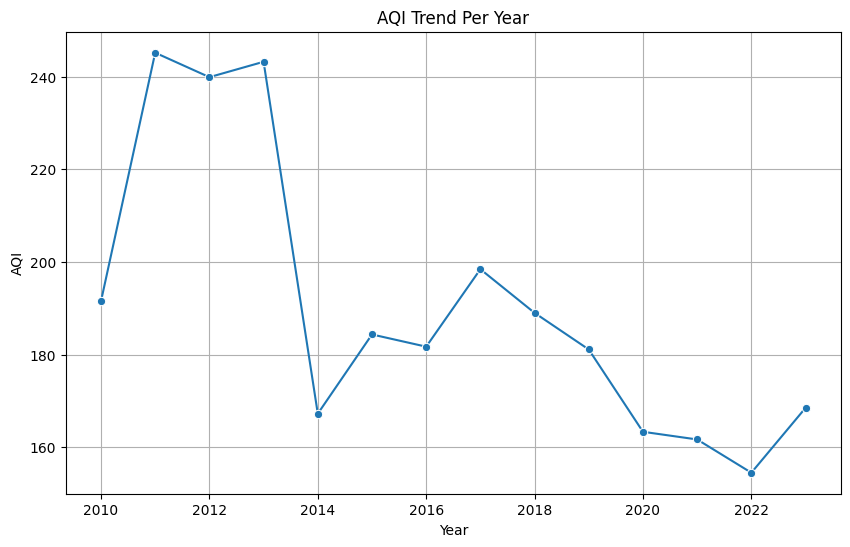

In [27]:

data_pd = data.select("year", "AQI").toPandas()

aqi_trend = data_pd.groupby("year")["AQI"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=aqi_trend, x="year", y="AQI", marker='o')
plt.title("AQI Trend Per Year")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.grid(True)
plt.show()


# Model Training

#### Test Train Split

In [28]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

#### Model Training

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import sys

try:
    assembler = VectorAssembler(inputCols=["year"], outputCol="features")
    rf = RandomForestRegressor(featuresCol="features", labelCol="AQI")

    pipeline = Pipeline(stages=[assembler, rf])

    model = pipeline.fit(train_data)

    predictions = model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

except Exception as e:
    print("An error occurred:", e)
    print("Traceback:", sys.exc_info()[0])


#### RMSE

In [35]:
print("Root Mean Squared Error :", rmse)

Root Mean Squared Error : 137.89


In [37]:
spark.stop()